In [691]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [692]:
using Interpolations
using Printf
using Optim
using PyPlot
using LinearAlgebra
using HDF5

In [693]:
function read_from_hdf5(h5file,obs_name)
	fid = h5open(h5file,"r")
	temps = fid["temperatures"][:]
	obs   = fid[obs_name*"/mean"]
	times = [i for i in 1:size(obs)[1]]
	return temps,obs,times
end

read_from_hdf5 (generic function with 1 method)

In [694]:
h5file = "2d_out.h5"
obs_name = "mq_sqrt3_corr"
temps,m_data,times = read_from_hdf5(h5file,obs_name)

([0.8, 0.805, 0.81, 0.815, 0.82, 0.825, 0.83, 0.835, 0.84, 0.845  …  0.855, 0.86, 0.865, 0.87, 0.875, 0.88, 0.885, 0.89, 0.895, 0.9], HDF5.Dataset: /mq_sqrt3_corr/mean (file: 2d_out.h5 xfer_mode: 0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001])

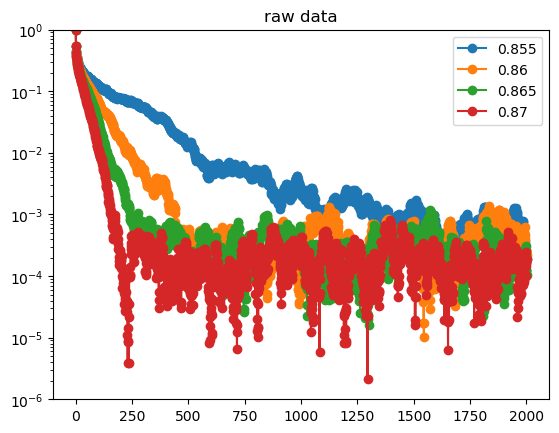

In [695]:
# cut too low temperature datas
num_temps = length(temps)
min_temp  = 12
max_temp  = 15
for it in min_temp:max_temp
	plt.semilogy(times,m_data[:,it],marker="o",label="$(temps[it])")
end
plt.title("raw data")
plt.ylim(1e-6,1)
plt.legend(loc="upper right")
plt.show()

In [696]:
#load average data from text file
temps = [0.855,0.860,0.865,0.870]
file_idx = [2,3,4,5]
num_temps = length(temps)
mc_steps  = 201
m_data = Array{Float64}(undef,mc_steps,num_temps)
counter = 1
for ifl in file_idx
	open("mq_sqrt3_$(ifl)_ave.dat","r") do fp
		for is in 1:mc_steps
			str = split(readline(fp))
			m_data[is,counter] = parse(Float64,str[2])
		end
	end
	counter += 1
end

In [697]:
m_data

201×4 Array{Float64,2}:
 1.0        1.0        1.0         1.0
 0.546513   0.542998   0.538791    0.535052
 0.441947   0.435596   0.429039    0.422953
 0.392316   0.383992   0.375166    0.367013
 0.361417   0.351774   0.342163    0.331684
 0.34014    0.329      0.317551    0.305504
 0.323767   0.312002   0.297938    0.285406
 0.310723   0.297655   0.283173    0.26923
 0.299732   0.285401   0.270452    0.25571
 0.290756   0.275821   0.258765    0.243227
 0.282245   0.266541   0.249206    0.232219
 0.274787   0.258992   0.240256    0.221733
 0.268253   0.251907   0.231769    0.212879
 ⋮                                 
 0.0738051  0.0218989  0.00315327  0.000225948
 0.0731491  0.0217034  0.00307645  0.000210268
 0.0724448  0.0212778  0.00302245  0.000206369
 0.0718854  0.02112    0.0029151   0.000195777
 0.0711139  0.0208957  0.00293776  0.00019455
 0.0706688  0.0209127  0.00290394  0.000181925
 0.070198   0.0203896  0.00281847  0.00017284
 0.0698176  0.0201096  0.00278793  0.000171467
 

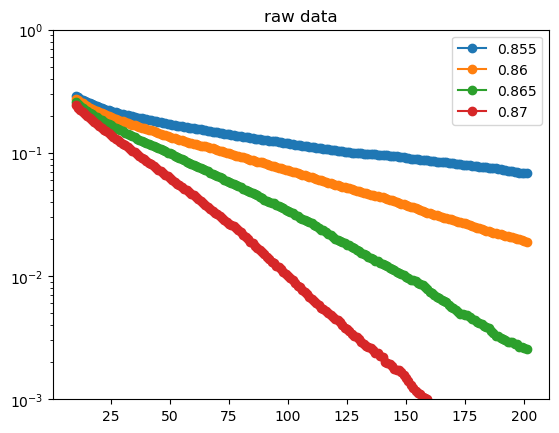

4


In [698]:
num_temps = length(temps)
println(num_temps)
times = [i for i in 1:size(m_data)[1]]
for it in 1:num_temps
	plt.semilogy(times[10:end],m_data[:,it][10:end],marker="o",label="$(temps[it])")
end
plt.title("raw data")
plt.ylim(1e-3,1)
plt.legend(loc="upper right")
plt.show()

In [699]:
# reshape some datas for optimization.
min_temp = 1
max_temp = 4
temps  = temps[min_temp:max_temp]
num_temps = length(temps)
m_data = m_data[:,min_temp:max_temp]


201×4 Array{Float64,2}:
 1.0        1.0        1.0         1.0
 0.546513   0.542998   0.538791    0.535052
 0.441947   0.435596   0.429039    0.422953
 0.392316   0.383992   0.375166    0.367013
 0.361417   0.351774   0.342163    0.331684
 0.34014    0.329      0.317551    0.305504
 0.323767   0.312002   0.297938    0.285406
 0.310723   0.297655   0.283173    0.26923
 0.299732   0.285401   0.270452    0.25571
 0.290756   0.275821   0.258765    0.243227
 0.282245   0.266541   0.249206    0.232219
 0.274787   0.258992   0.240256    0.221733
 0.268253   0.251907   0.231769    0.212879
 ⋮                                 
 0.0738051  0.0218989  0.00315327  0.000225948
 0.0731491  0.0217034  0.00307645  0.000210268
 0.0724448  0.0212778  0.00302245  0.000206369
 0.0718854  0.02112    0.0029151   0.000195777
 0.0711139  0.0208957  0.00293776  0.00019455
 0.0706688  0.0209127  0.00290394  0.000181925
 0.070198   0.0203896  0.00281847  0.00017284
 0.0698176  0.0201096  0.00278793  0.000171467
 

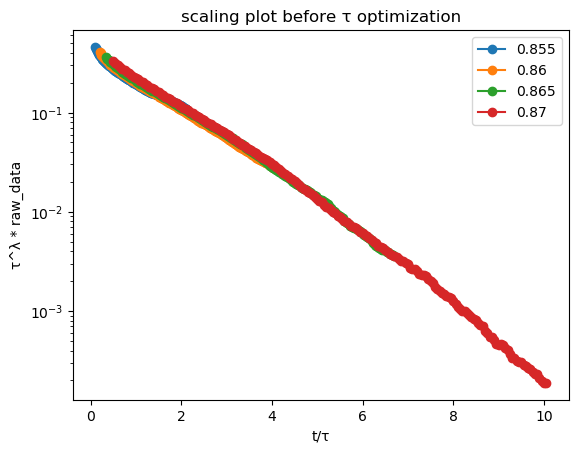

In [700]:
# search configuration of tau which put some curves on one curve.
taus   = [95.,50.,30.,20.0]
@assert length(taus) == max_temp - min_temp + 1
lambda = 0.1
plt.figure()
for it in 1:num_temps
	plt.semilogy(times[10:end] ./ taus[it],(taus[it]^lambda)*m_data[:,it][10:end],marker="o",label="$(temps[it])")
	
end
plt.title("scaling plot before τ optimization")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * raw_data")
plt.legend(loc="upper right")
plt.show()

In [701]:
"""
params: [tau1, tau2, ...]
"""
function cost(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[20] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    g_mean = sum(g_intpl, dims=2) ./ length(temps)
    norm(g_intpl .- g_mean[:, newaxis])^2 /  norm(g_mean)^2
end

cost

In [702]:
res = Optim.optimize(cost, taus)
res

 * Status: success

 * Candidate solution
    Final objective value:     2.910917e-03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    73
    f(x) calls:    143


In [703]:
taus_opt = Optim.minimizer(res)

4-element Array{Float64,1}:
 97.28048978993733
 49.94117152353961
 31.851446512428726
 22.323421017693228

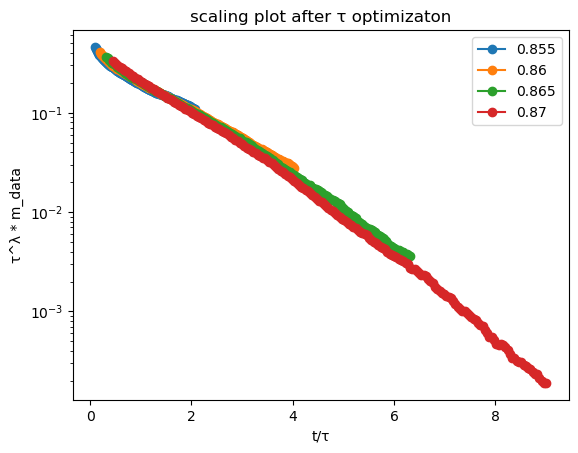

In [704]:
plt.figure()
for it in eachindex(temps)
	plt.semilogy(times[10:end] ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it][10:end], marker="o",label="$(temps[it])")
    #println((taus[it]^lambda) * m_data[:, it])
end
plt.title("scaling plot after τ optimizaton")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * m_data")
plt.legend(loc="upper right")
plt.show()

In [705]:
x = 1.0
y = 0.9
n = 100
test = range(x,y,length=n)

1.0:-0.00101010101010101:0.9

In [706]:
test = LinRange(x,y,n)


100-element LinRange{Float64}:
 1.0,0.99899,0.99798,0.99697,0.99596,…,0.90404,0.90303,0.90202,0.90101,0.9